In [88]:
import os
from pathlib import Path
from collections import Counter

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import pollock.utils as utils

In this tutorial we will:
1. load in a PBMC test dataset
2. assign cell labels
3. train a pollock model
4. use model to predict cell types
5. evaluate model performance

NOTE: with the exception of adding a layer for raw count data, steps 1 and 2 are largely identical to the [scanpy 3k PBMC clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

## 1. load in pbmc data

if this is the first time you are running this notebook, you will need to run this cell to download and store the PBMC dataset

In [28]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

read in the 10x scRNA-seq data with scanpy

In [29]:
adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

Pollock models take raw counts (un-normalized) expression data as input. Here we add a layer to the anndata object with the raw counts so they can be stored for module training later.

In [30]:
counts_adata = adata.copy()

## 2. assign cell types

In the following cells we do preprocessing recommended by scanpy.

For more details see the [scanpy 3k PBMC clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

In [31]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata.raw = adata

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [32]:
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

sc.pp.scale(adata, max_value=10)

In [33]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

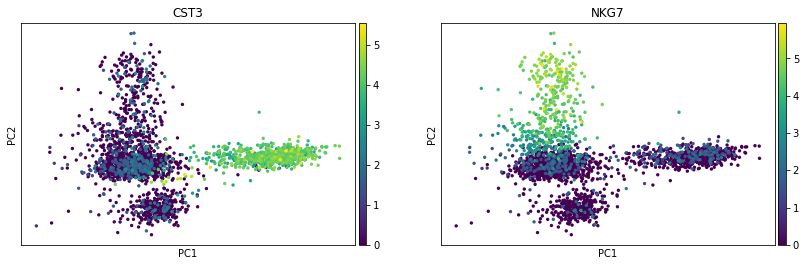

In [34]:
sc.pl.pca(adata, color=['CST3', 'NKG7'])

if you have not installed the leidenalg library yet, you will need to install it by uncommenting and running the following cell

In [35]:
# !conda install -y -c conda-forge leidenalg

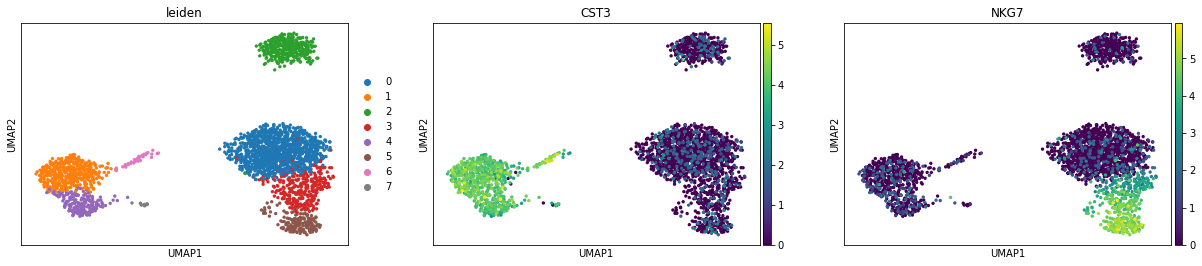

In [36]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [37]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

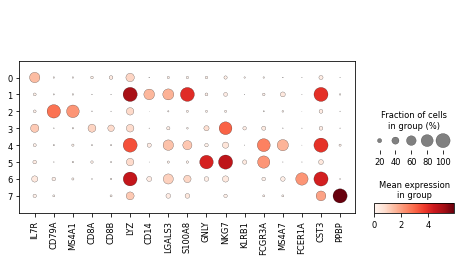

In [38]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

In [44]:
# note you may need to change these mappings depending on how the cells cluster
cluster_map = {
    'CD4 T': ['0'],
    'CD14 Monocytes': ['1'],
    'B': ['2'],
    'CD8 T': ['3'],
    'NK': ['5'],
    'FCGR3A Monocytes': ['4'],
    'Dendritic': ['6'],
    'Megakaryocytes': ['7']
    
}
r_cluster_map = {v:k for k, vs in cluster_map.items() for v in vs}
adata.obs['cell_type'] = [r_cluster_map[x] for x in adata.obs['leiden']]

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


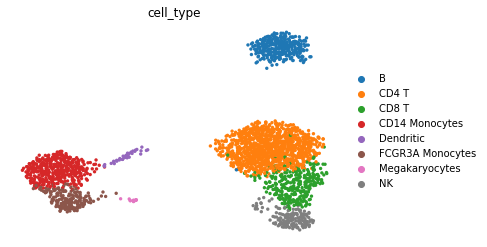

In [45]:
sc.pl.umap(adata, color='cell_type', frameon=False)

save the anndata object for later

In [46]:
adata.write_h5ad('data/pbmc.h5ad')

## 3. train pollock module

specify a location to save the trained pollock module

In [47]:
module_save_filepath = 'models/pbmc'
Path(module_save_filepath).mkdir(parents=True, exist_ok=True)

here we transfer cell types from the processed anndata object to the stored anndata object with raw counts

Pollock expects the raw counts data to be in the X attribute

In [49]:
counts_adata = counts_adata[adata.obs.index]
counts_adata.obs['cell_type'] = adata.obs['cell_type'].to_list()
counts_adata.obs.head()

Trying to set attribute `.obs` of view, copying.


,cell_type
AAACATACAACCAC-1,CD8 T
AAACATTGAGCTAC-1,B
AAACATTGATCAGC-1,CD4 T
AAACCGTGCTTCCG-1,FCGR3A Monocytes
AAACCGTGTATGCG-1,NK


take a look at our cell counts

In [50]:
Counter(train_adata.obs['cell_type']).most_common()

[('CD4 T', 1147),
 ('CD14 Monocytes', 478),
 ('B', 341),
 ('CD8 T', 301),
 ('NK', 163),
 ('FCGR3A Monocytes', 159),
 ('Dendritic', 36),
 ('Megakaryocytes', 13)]

lets take a look at the defaults pollock model training arguments

In [51]:
utils.DEFAULT_TRAIN_ARGS

{'lr': 0.0001,
 'epochs': 20,
 'batch_size': 64,
 'latent_dim': 64,
 'enc_out_dim': 128,
 'middle_dim': 512,
 'kl_scaler': 0.001,
 'clf_scaler': 1.0,
 'zinb_scaler': 0.5,
 'use_cuda': False,
 'cell_type_key': 'cell_type',
 'module_filepath': 'models/pbmc'}

Typically default training arguments will give good results, but below are descriptions of some key arguments.

Training arguments
  - latent_dim
    - size of latent embedding layer
  - enc_out_dim
    - output dimension of encoder
  - middle_dim
    - dimension of intermediate encoder and decoder layers
  - kl_scaler
    - how much to weight KL divergence loss
  - clf_scaler
    - how much to weight classification loss
  - zinb_scaler
    - how much to weight zinb reconstruction loss
  - cell_type_key
    - key in .obs where the cell type label is stored
  - use_cuda
    - whether to use gpu for model training
  - module_filepath
    - filepath to save pollock model

In [52]:
# we will use default train args
args = utils.DEFAULT_TRAIN_ARGS

# set the model save filepath
args['module_filepath'] = module_save_filepath

# if you have GPUs installed and visible on this machine you can train with gpu to significantly speed up model training
# args['use_cuda'] = True
args

{'lr': 0.0001,
 'epochs': 20,
 'batch_size': 64,
 'latent_dim': 64,
 'enc_out_dim': 128,
 'middle_dim': 512,
 'kl_scaler': 0.001,
 'clf_scaler': 1.0,
 'zinb_scaler': 0.5,
 'use_cuda': False,
 'cell_type_key': 'cell_type',
 'module_filepath': 'models/pbmc'}

next we need to create our training and validation datasets

typically we recommend balancing the training dataset to ensure that each cell type is equally represented

here we use the built in get_splits function to create our training dataset. 80% of cells for each cell type will be put in a training pool that is then drawn from to create even numbers of each cell type.

In [79]:
# get train ids
train_ids, remaining_ids = utils.get_splits(counts_adata, 'cell_type', n_per_cell_type=500,
                                            oversample=True, split=.8)

# get validation ids from remaining ids. here we take min(num cells remaining, 100) cells for each cell type.
val_ids, _ = utils.get_splits(counts_adata[remaining_ids], 'cell_type', n_per_cell_type=100,
                              oversample=False, split=1.)

train, val = counts_adata[train_ids], counts_adata[val_ids]
train.shape, val.shape

((4000, 32738), (493, 32738))

In [80]:
Counter(train.obs['cell_type']).most_common()

[('CD8 T', 500),
 ('B', 500),
 ('CD4 T', 500),
 ('FCGR3A Monocytes', 500),
 ('NK', 500),
 ('CD14 Monocytes', 500),
 ('Dendritic', 500),
 ('Megakaryocytes', 500)]

In [81]:
Counter(val.obs['cell_type']).most_common()

[('CD4 T', 100),
 ('CD8 T', 100),
 ('B', 100),
 ('CD14 Monocytes', 100),
 ('FCGR3A Monocytes', 46),
 ('NK', 36),
 ('Dendritic', 8),
 ('Megakaryocytes', 3)]

In [82]:
utils.train_and_save_model(train, val, args)

2022-01-24 08:48:09,074 beginning training
2022-01-24 08:48:09,076 creating dataloaders
Trying to set attribute `.var` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.var` of view, copying.
2022-01-24 08:48:11,340 12775 genes over

note: if it appears that the model is either overfitting (validation loss hits minimum and then starts rising) or underfitting (validation loss is still dropping and has yet to flatten out) it may be benificial to adjust the args['epochs'] parameter to train the model for a shorter or longer period of time. Here we could probably get away with training for a few more epochs, but for the sake of the demo we will keep the number of defaults to the default value.

## 4. cell type prediction

lets now predict all the cells in the anndata object by loading the model we just created.

In [83]:
model = utils.load_model(module_save_filepath)

In [84]:
# note that if you are predicting a large dataset and don't need the pollock umap embeddings you can set make_umap to False to increase runtime speed
adata = utils.predict_adata(model, counts_adata, make_umap=True)
adata

2022-01-24 08:55:40,291 15522 genes overlap with model after filtering
2022-01-24 08:55:40,292 0 genes missing from dataset after filtering
2022-01-24 08:55:40,955 starting prediction of 2638 cells


AnnData object with n_obs × n_vars = 2638 × 15522
    obs: 'cell_type', 'n_counts', 'size_factors', 'y_pred', 'predicted_cell_type_probability', 'predicted_cell_type', 'probability B', 'probability CD14 Monocytes', 'probability CD4 T', 'probability CD8 T', 'probability Dendritic', 'probability FCGR3A Monocytes', 'probability Megakaryocytes', 'probability NK'
    var: 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_emb', 'X_umap', 'prediction_probs'

after prediction we have several additions to the anndata object

predicted cell type and prediction probabilities are now columns in .obs

In [85]:
adata.obs

,cell_type,n_counts,size_factors,y_pred,predicted_cell_type_probability,predicted_cell_type,probability B,probability CD14 Monocytes,probability CD4 T,probability CD8 T,probability Dendritic,probability FCGR3A Monocytes,probability Megakaryocytes,probability NK
AAACATACAACCAC-1,CD8 T,2421.0,1.093496,3,0.968388,CD8 T,0.005466,0.004671,0.006951,0.968388,0.004934,0.001072,0.006036,0.002482
AAACATTGAGCTAC-1,B,4903.0,2.214544,0,0.970875,B,0.970875,0.004994,0.003239,0.004696,0.007421,0.002207,0.002578,0.003988
AAACATTGATCAGC-1,CD4 T,3149.0,1.422312,2,0.817220,CD4 T,0.028100,0.021294,0.817220,0.051556,0.023152,0.016095,0.012893,0.029690
AAACCGTGCTTCCG-1,FCGR3A Monocytes,2639.0,1.191960,5,0.993492,FCGR3A Monocytes,0.000288,0.000527,0.000385,0.000156,0.002156,0.993492,0.002012,0.000985
AAACCGTGTATGCG-1,NK,981.0,0.443089,7,0.988920,NK,0.000563,0.001493,0.001646,0.001599,0.002752,0.002221,0.000806,0.988920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,CD14 Monocytes,3460.0,1.562782,1,0.890563,CD14 Monocytes,0.010560,0.890563,0.006010,0.014050,0.015642,0.036789,0.018959,0.007428
TTTCTACTGAGGCA-1,B,3447.0,1.556911,0,0.968997,B,0.968997,0.005630,0.003428,0.005903,0.006739,0.002401,0.002882,0.004021
TTTCTACTTCCTCG-1,B,1684.0,0.760614,0,0.981728,B,0.981728,0.003461,0.002377,0.003659,0.003706,0.001434,0.001429,0.002205
TTTGCATGAGAGGC-1,B,1024.0,0.462511,0,0.970921,B,0.970921,0.004670,0.003288,0.004771,0.007301,0.002747,0.002806,0.003496


the pollock cell embeddings, along with their 2-D umap decomposed counterparts are in adata.obsm

In [86]:
adata.obsm['X_emb'].shape, adata.obsm['X_umap'].shape

((2638, 64), (2638, 2))

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


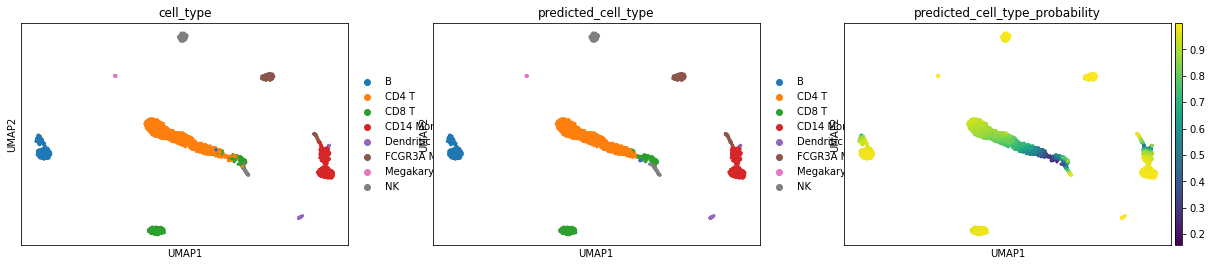

In [87]:
sc.pl.umap(adata, color=['cell_type', 'predicted_cell_type', 'predicted_cell_type_probability'])

## 5. model performance

In [90]:
def get_metrics(y_true_labels, y_pred_labels):
    classes = sorted(set(y_true_labels))

    y_pred = [classes.index(c) for c in y_pred_labels]
    y_true = [classes.index(c) for c in y_true_labels]

    clf_report = classification_report(y_true, y_pred, labels=list(range(len(classes))), target_names=classes,
                             output_dict=True)
    clf_report = pd.DataFrame.from_dict(clf_report)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    cm = pd.DataFrame(data=cm, index=classes, columns=classes)
    
    clf_report.index.name = 'metric'
    cm.index.name = 'cell_type'
    
    return clf_report, cm

In [97]:
# using only validation anndata to look at performance metrics
val_adata = adata[val_ids]
y_pred = val_adata.obs['predicted_cell_type'].to_list()
y_true = val_adata.obs['cell_type'].to_list()
clf_report, cm = get_metrics(y_true, y_pred)

with the confusion matrix we can visualize how cells are being classified

Text(32.99999999999999, 0.5, 'manual annotation')

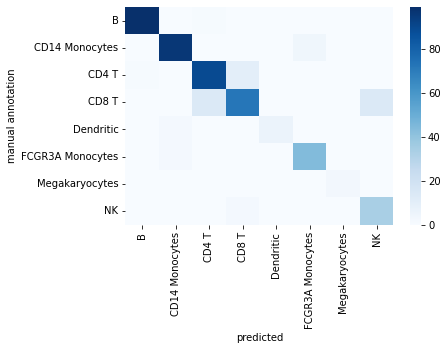

In [98]:
sns.heatmap(cm, cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('manual annotation')

normalized to # of cells

Text(32.99999999999999, 0.5, 'manual annotation')

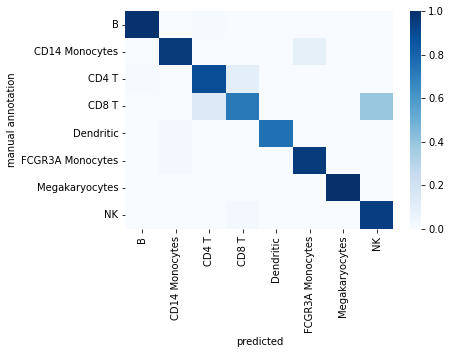

In [100]:
sns.heatmap(cm / cm.sum(axis=1), cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('manual annotation')

we can also look at the precision, recall, and f1-score for all cell types

In [99]:
clf_report

,B,CD14 Monocytes,CD4 T,CD8 T,Dendritic,FCGR3A Monocytes,Megakaryocytes,NK,accuracy,macro avg,weighted avg
metric,,,,,,,,,,,
precision,0.99,0.96,0.855769,0.857143,1.000000,0.916667,1.0,0.708333,0.89858,0.910989,0.902551
recall,0.99,0.96,0.890000,0.720000,0.750000,0.956522,1.0,0.944444,0.89858,0.901371,0.898580
f1-score,0.99,0.96,0.872549,0.782609,0.857143,0.936170,1.0,0.809524,0.89858,0.900999,0.897727
support,100.00,100.00,100.000000,100.000000,8.000000,46.000000,3.0,36.000000,0.89858,493.000000,493.000000
